# Computer Vision Project

### Setup

In [1]:
import os
import importlib
from tqdm import tqdm

# Torch modules
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch import amp

# Custom modules
import segmentation.utils
importlib.reload(segmentation.utils)
from segmentation.utils import preprocessing, model_utils

import segmentation.dataset
importlib.reload(segmentation.dataset)
from segmentation.dataset import PointDataset
from segmentation.show import *

from models.unet_model import UNET


/opt/miniconda3/envs/cv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Defining some constants that will be used throughout the notebook
DATA_DIR = 'Dataset/'
x_test_dir = os.path.join(DATA_DIR, 'Test/color')
y_test_dir = os.path.join(DATA_DIR, 'Test/label')
x_trainVal_dir = os.path.join(DATA_DIR, 'TrainVal/color')
y_trainVal_dir = os.path.join(DATA_DIR, 'TrainVal/label')

### Splitting the TrainVal data into training and validation data
* Splitting into training and validations sets is needed so we can evaluate peformance on the model while training.
* More common than K-fold cross validation in deep learning settings because of computational costs.

In [767]:
# Getting a list of relative paths to the images (x) and the masks/labels (y)
x_test_fps, y_test_fps = preprocessing.get_testing_paths(x_test_dir, y_test_dir)

# Splitting relative path names into into training and validation
x_train_fps, x_val_fps, y_train_fps, y_val_fps = preprocessing.train_val_split(x_trainVal_dir, y_trainVal_dir, 0.2)


### Custom Dataset

In [768]:
test_augmentation = preprocessing.get_validation_augmentation()
preprocessing_fn = preprocessing.get_preprocessing()
train_augmentation = preprocessing.get_training_augmentation()


train_dataset = CVDataset(x_train_fps, y_train_fps, preprocessing=preprocessing_fn, augmentation=train_augmentation)
valid_dataset = CVDataset(x_val_fps, y_val_fps)

test_dataset  = CVDataset(
                x_test_fps[:10],
                y_test_fps[:10],
                augmentation = test_augmentation,
                preprocessing=preprocessing_fn
                )


# Printing the size of each dataset
print(f'Training dataset has size {train_dataset.__len__()}')
print(f'Validation dataset has size {valid_dataset.__len__()}')
print(f'Testing dataset has size {test_dataset.__len__()}')

Training dataset has size 2938
Validation dataset has size 735
Testing dataset has size 10


In [769]:
test_dataset.original_dimensions

AttributeError: 'CVDataset' object has no attribute 'original_dimensions'

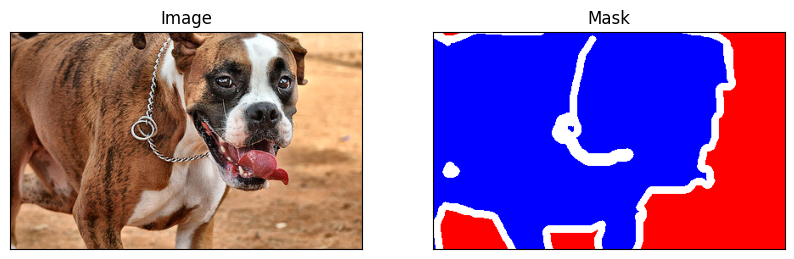

In [770]:

image, mask = train_dataset[23]
c_mask = colorise_mask(mask, VisualisationConstants.palette)
visualise_data(image = image, mask = c_mask)


In [771]:
colorise_mask(mask, VisualisationConstants.palette).shape

torch.Size([3, 256, 416])

## Saving the model

In [772]:
# 0. Create your model and train it
model = unet_model.UNET(in_channels=3, out_channels=3)
# train function/code or whatever you need to use

# 1. get the state dict for the model (weights etc)
#    This is a built in method if model inherits from nn.Module
state_dict = model.state_dict()

# 2. Create a checkpoint
checkpoint = {'state_dict': state_dict, # 'state_dict' key name must be named state_dict exactly
              'epochs':10,              # Add optional additional elements to the checkpoint for experiment tracking
              'learning_rate': 10}      # these can be named whatever you like, and there can be as many as you like

# 3. save the checkpoint to your computer/google colab files
model_utils.save_checkpoint(
    checkpoint,
    'test.pth'  # Where you want to save & filename, if you want to save to folder called 'checkpoints' for instance, just change to 'checkpoints/test.pth'
    )

NameError: name 'unet_model' is not defined

## Loading the model 

In [670]:
import segmentation.utils
importlib.reload(segmentation.utils)
from segmentation.utils import ModelEval

ImportError: cannot import name 'ModelEval' from 'segmentation.utils' (/Users/georgeboutselis/Library/CloudStorage/OneDrive-UniversityofEdinburgh/Year 4/Semester 2/Computer Vision/Computer-Vision-Project/segmentation/utils.py)

## Point based segmentation

In [671]:
import segmentation.dataset
importlib.reload(segmentation.dataset)
from segmentation.dataset import CVDataset
from segmentation.dataset import PointDataset
import segmentation.utils
importlib.reload(segmentation.utils)

import torchvision.transforms.functional as TF
import torch

In [672]:
from segmentation.eval import *

In [673]:
train_augmentation = preprocessing.get_training_augmentation()
preprocessing_fn = preprocessing.get_preprocessing()
val_augmentation = preprocessing.get_validation_augmentation()

train_dataset = PointDataset(x_train_fps[:5], y_train_fps[:5], augmentation=train_augmentation, preprocessing=preprocessing_fn, concat_heatmap=True)
val_dataset  = PointDataset(x_val_fps, y_val_fps, augmentation=val_augmentation, preprocessing=preprocessing_fn)

train_loader = DataLoader(train_dataset,batch_size= 8,num_workers=4,pin_memory=True,shuffle=True)

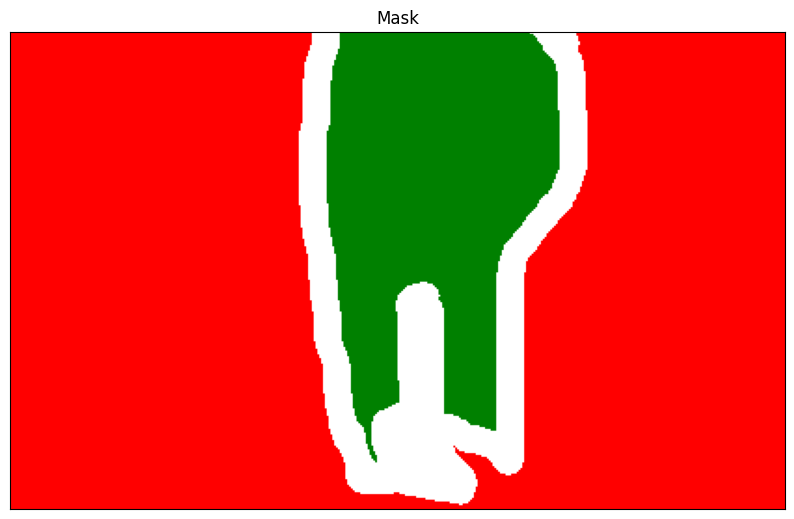

In [764]:
image, mask = train_dataset[0]
from segmentation.constants import VisualisationConstants
colour_mask = colorise_mask(mask, VisualisationConstants.palette)
visualise_data(mask = colour_mask)

In [578]:
image = image.float().to('mps')

In [599]:
mask.shape

torch.Size([256, 416])

In [600]:
for image, mask in train_loader:
    print(mask.shape)

original mask has shape (500, 333)
running
prompt point is [329, 332]
keypoint is :[[370.0, 92.0], [378.0, 92.0]]
original mask has shape (375, 500)
running
prompt point is [117, 289]
keypoint is :[]
running
prompt point is [216, 229]
keypoint is :[[216.0, 229.0]]
original mask has shape (500, 375)
running
prompt point is [36, 32]
keypoint is :[]
running
prompt point is [179, 109]
keypoint is :[[236.0, 109.0]]
original mask has shape (375, 500)
running
prompt point is [33, 85]
keypoint is :[]
running
prompt point is [10, 227]
keypoint is :[[405.0, 227.0]]
original mask has shape (333, 500)
running
prompt point is [483, 65]
keypoint is :[[16.0, 14.0]]
torch.Size([5, 256, 416])


KeyboardInterrupt: 

In [582]:

model(image.unsqueeze(0)).shape

torch.Size([1, 2, 256, 416])

In [602]:
predicted_masks = torch.rand((10, 2, 256, 416))
torch.argmax(predicted_masks, dim = 1).shape

torch.Size([10, 256, 416])

In [594]:

import segmentation.metrics
importlib.reload(segmentation.metrics)
from segmentation.metrics import *

In [ ]:
metric.compute_iou_from_logits(predicted_masks, )

TypeError: Metrics.compute_iou_from_logits() missing 1 required positional argument: 'ground_truths'

In [595]:
metric = Metrics(2)

In [552]:
import numpy as np
np.unique_counts(mask)

UniqueCountsResult(values=array([  0,   1, 255], dtype=uint8), counts=array([91084,  8472,  6940]))

In [139]:
from segmentation.dataset import CVDataset
train_dataset = CVDataset(x_train_fps[:5], y_train_fps[:5], augmentation=train_augmentation)
image, mask = train_dataset[1]

In [254]:
sample_prompt(mask)

array([168,  77])

In [219]:
from segmentation.eval import predict

In [220]:
image = image.float()
predict(image, unet_model)

AttributeError: 'numpy.ndarray' object has no attribute 'float'

<Axes: xlabel='epoch', ylabel='metric'>

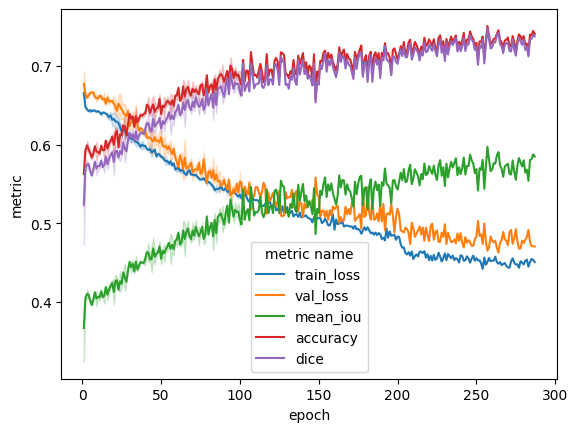

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('/Users/georgeboutselis/Downloads/training_log-10.csv')
df = df.melt(id_vars= 'epoch', var_name='metric name', value_name='metric')
sns.lineplot(x = 'epoch', y = 'metric', hue = 'metric name', data = df)

In [19]:
df

,epoch,metric name,metric
0,1,train_loss,0.670117
1,2,train_loss,0.648202
2,3,train_loss,0.645782
3,4,train_loss,0.641588
4,5,train_loss,0.640718
...,...,...,...
955,86,dice,0.675370
956,87,dice,0.663260
957,88,dice,0.674250
958,89,dice,0.651720


<Axes: xlabel='epoch'>

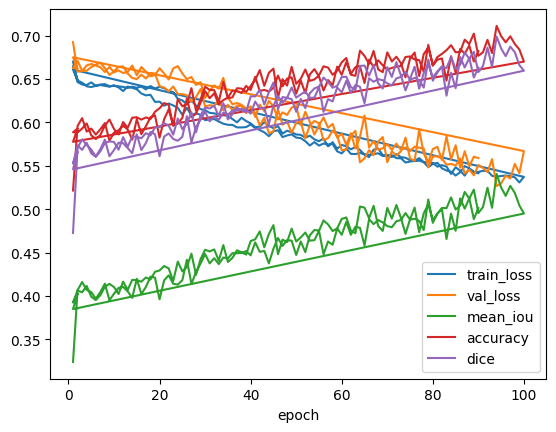

In [7]:
df.set_index('epoch').plot()